In [20]:
from causalimpact import CausalImpact

import numpy as np
import pandas as pd
import datetime
from datetime import datetime

from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters

In [22]:
from statsmodels.tsa.arima_model import ARIMA

In [49]:
import warnings
warnings.filterwarnings("ignore")

# **Data**

In [23]:
data = pd.read_csv("KOEPPEL FUNNEL.csv", parse_dates=['Date'])

In [24]:
print('Time period is: from ', data.Date.min().date(), ' to ', data.Date.max().date())

Time period is: from  2022-03-14  to  2022-10-30


In [25]:
#remove last row: totals
data = data.dropna(how='any', subset=['Date'], axis = 0)

Changing data types

In [26]:
data['tCVR'] = data['tCVR'].str.rstrip("%").astype(float)/100

data['CPT'] = data.CPT.str[1:].astype(str).astype(float)
data['CPI'] = data.CPI.str[1:].astype(str).astype(float)
data['Spend'] = data.Spend.str[1:].str.replace(',', '').astype(str).astype(float)
data['Rate'] = data.Rate.str[1:].astype(str).astype(float)

data['Frequency'] = data['Frequency'].astype(str).astype(int)

data['Trials'] = data['Trials'].astype(str).astype(int)

data['Installs'] = data['Installs'].str.replace(',', '').astype(str).astype(int)

In [27]:
data=data.sort_values(by=['Date'])
#reset indexes
data.reset_index(drop=True, inplace = True)

In [28]:
# Set pre-period
pre_period = [str(data.Date.min())[:10], str('2022-10-19')]
# Set post-period
post_period = [str('2022-10-20'), str(data.Date.max())[:10]]

# **Casual Impact model**

In [29]:
model_data=data[['Date', 'Trials']]
model_data.set_index('Date', inplace=True)

C:\Users\mgrgic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


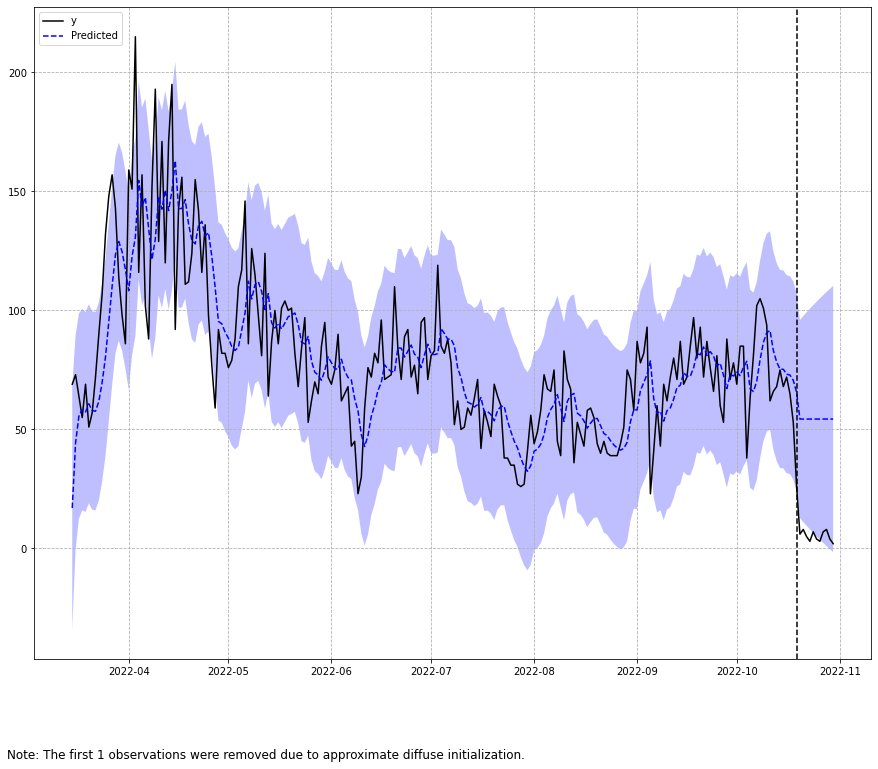

In [33]:
# Causal impact model, prior_level_sd default of 0.01
impact_15 = CausalImpact(data=model_data.Trials, pre_period=pre_period, post_period=post_period, prior_level_sd = 0.15)
impact_15.plot(panels=['original'])

In [238]:
print(impact_try.summary('report'))
#downlift: -49.19
#trials predicted: 598.13

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 5.18. By contrast, in the absence of an
intervention, we would have expected an average response of 54.38.
The 95% interval of this counterfactual prediction is [19.85, 85.82].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -49.19 with a 95% interval of
[-80.63, -14.67]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 57.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 598.13. The 95% interval of this prediction is [218.39, 943.98].


The above results are given in terms of absolute numbers. In relative
terms, the response variab

# **ARIMA**

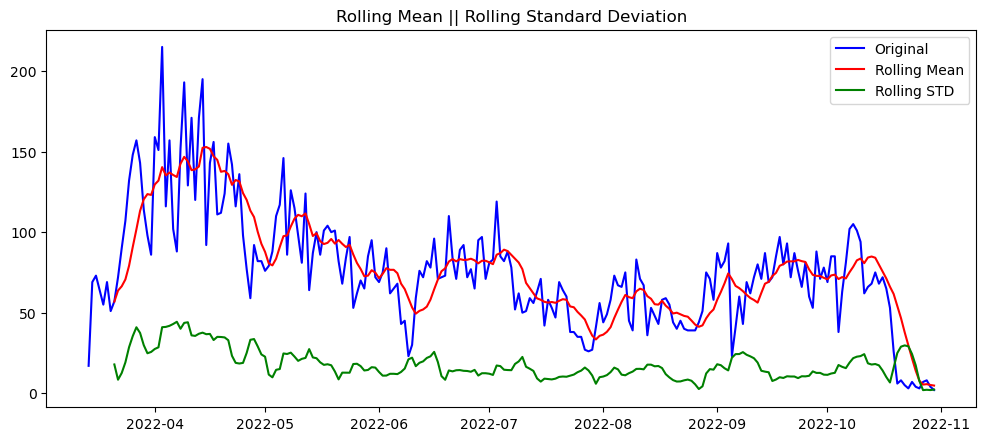

In [35]:
rolling_mean = model_data.rolling(window = 8).mean()
rolling_std = model_data.rolling(window = 8).std()

# ploting the data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_data, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'green', label = 'Rolling STD')
plt.legend(loc = 'best')
plt.title('Rolling Mean || Rolling Standard Deviation')
plt.show()

In [36]:
result = adfuller(model_data['Trials'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.6803319735368305
P-Values: 0.4412734588178363
Critical Values: 
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


Time series is non stationary!

In [203]:
#in one function:

In [37]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Trials'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

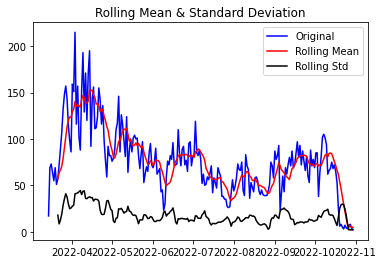

ADF Statistic: -1.6803319735368305
p-value: 0.4412734588178363
Critical Values:
	1%: -3.460154163751041
	5%: -2.874648939216792
	10%: -2.5737567259151044


In [38]:
get_stationarity(model_data)

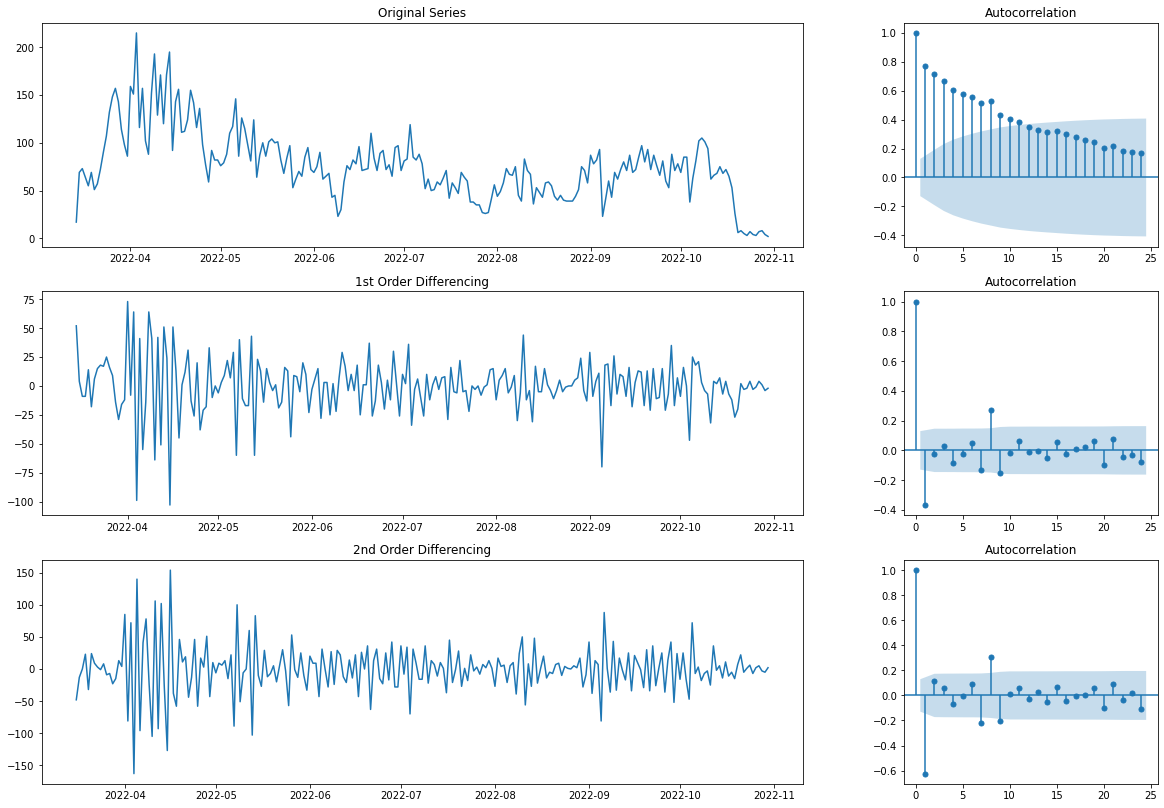

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2,gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 14))
axes[0, 0].plot(model_data['Trials']); axes[0, 0].set_title('Original Series')
plot_acf(model_data['Trials'], ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(model_data['Trials'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(model_data['Trials'].diff().dropna(), ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(model_data['Trials'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(model_data['Trials'].diff().diff().dropna(), ax=axes[2, 1])
plt.show()

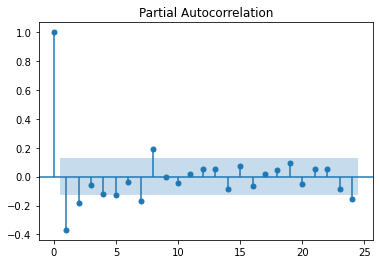

In [40]:
plot_pacf(model_data['Trials'].diff().dropna())
plt.show()

In [287]:
#p=4?

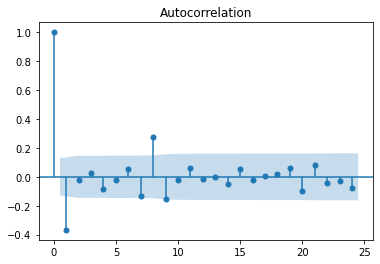

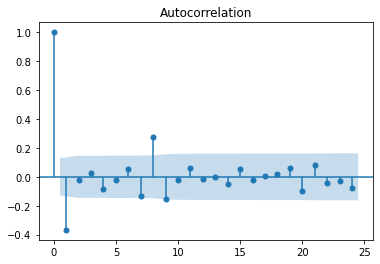

In [41]:
plot_acf(model_data['Trials'].diff().dropna()) #q=3

In [51]:
from statsmodels.tsa.arima_model import ARIMA
# ARIMA order (p,d,q)
model = ARIMA(model_data['Trials'], order=(4,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Trials   No. Observations:                  230
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1026.106
Method:                       css-mle   S.D. of innovations             20.766
Date:                Mon, 05 Dec 2022   AIC                           2070.211
Time:                        18:30:26   BIC                           2101.154
Sample:                    03-15-2022   HQIC                          2082.693
                         - 10-30-2022                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1838      0.560     -0.328      0.743      -1.282       0.915
ar.L1.D.Trials    -0.8686      0.135     -6.447      0.000      -1.133      -0.605
ar.L2.D.Trials    -0.6358      0.215

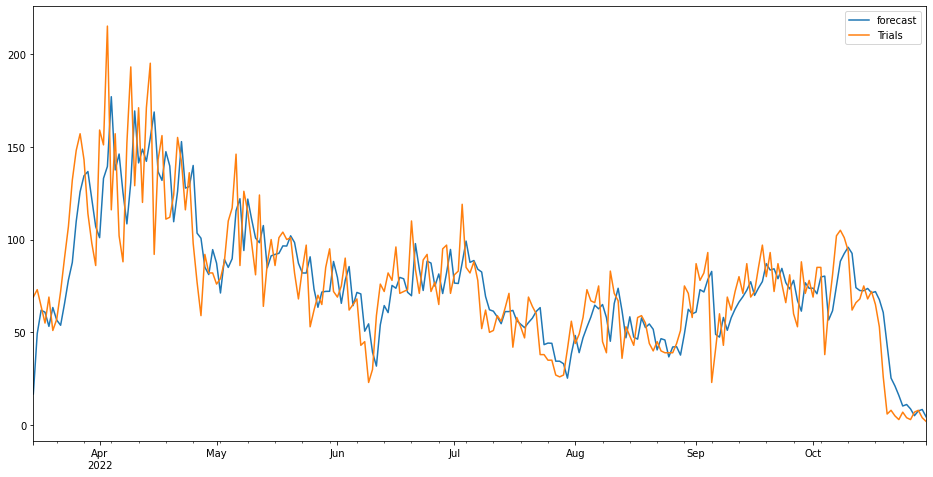

In [86]:
plt.rc("figure", figsize=(16,8))
model_fit.plot_predict(dynamic=False)
plt.show()

In [65]:
train =  model_data.loc[model_data.index <= '2022-10-19', 'Trials']

In [66]:
model_data.shape

(231, 1)

In [67]:
test = model_data.loc[model_data.index > '2022-10-19', 'Trials']

In [68]:
import numpy as np
model = ARIMA(train, order=(4,1,3))  
fitted = model.fit(disp=0)

In [69]:
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Trials   No. Observations:                  219
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -979.662
Method:                       css-mle   S.D. of innovations             21.006
Date:                Mon, 05 Dec 2022   AIC                           1977.323
Time:                        18:32:48   BIC                           2007.825
Sample:                    03-15-2022   HQIC                          1989.642
                         - 10-19-2022                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0067      0.504      0.013      0.989      -0.980       0.994
ar.L1.D.Trials    -0.8575      0.122     -7.048      0.000      -1.096      -0.619
ar.L2.D.Trials    -0.6153      0.195

In [70]:
# Forecast
fc, se, conf = fitted.forecast(11, alpha=0.05)

In [71]:
mape = np.mean(np.abs(fc - test)/np.abs(test))  # MAPE

In [72]:
mape

11.099459209078141

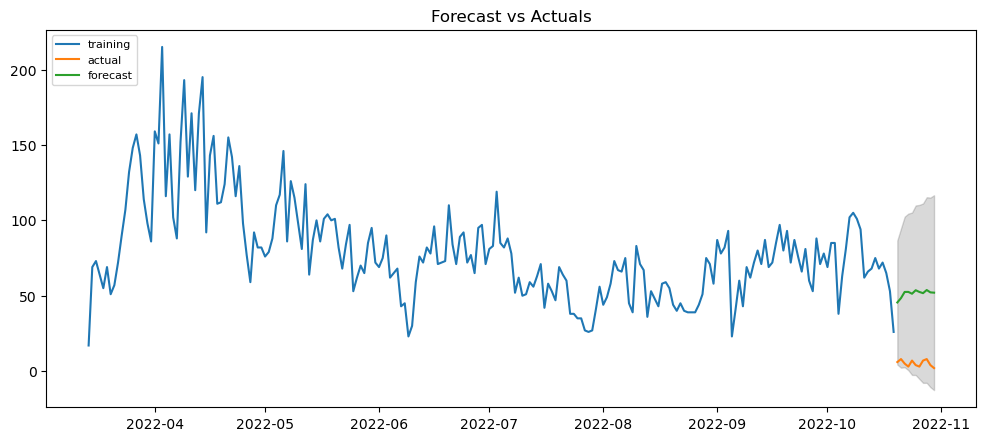

In [73]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

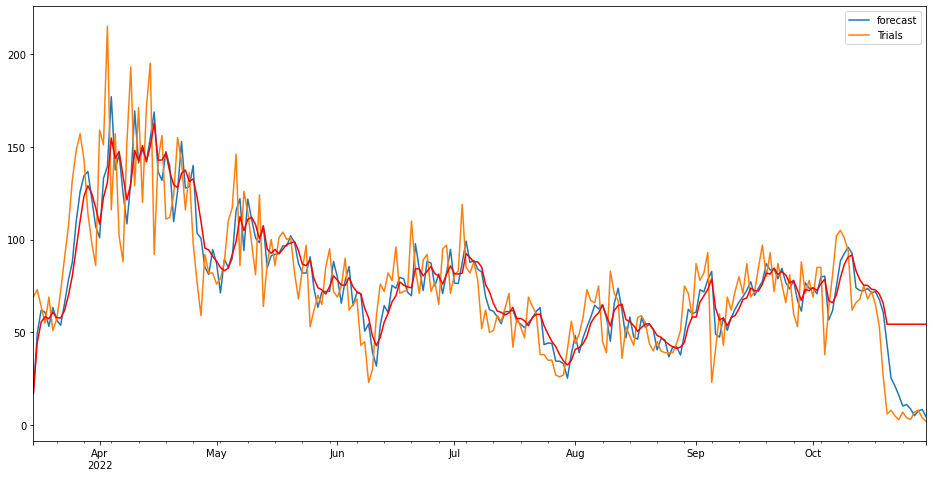

In [85]:
plt.rc("figure", figsize=(16,8))
model_fit.plot_predict(dynamic=False)
plt.plot(impact_15.inferences.preds, color = 'red')
plt.show()